In [1]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from dataset.cityscapes import *
from dataset.transforms import * 
from dataset.utils import *
import torch
from torch import nn
from torch.utils.data import DataLoader
import time
import argparse
from progress.bar import IncrementalBar
from dataset import Cityscapes
from dataset import transforms as T
from gan.generator4 import Generator
from gan.discriminator4 import Discriminator
from gan.criterion import GeneratorLoss, DiscriminatorLoss
from gan.utils import *
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

In [2]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Code runs in {device}")

Code runs in cuda:0


In [3]:
# Hyperparameters
epochs = 200
batch_size = 1
lr = 0.0002
save_image_interval = 2

In [4]:
#transforms = T.Compose([T.ToTensor()])


transforms = T.Compose([#T.HorizontalFlip(),
                        #T.CustomColorJitter(),
                        T.ToTensor(),
                        #T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                        ])      

cityscapes = Cityscapes(transform=transforms)
train_set, val_set, test_set = cityscapes.divide_into_sets()


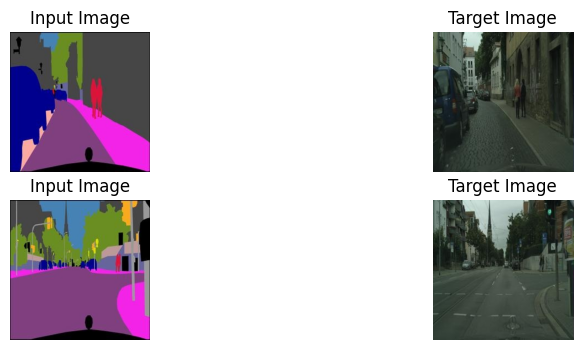

In [5]:
# Assuming 'train_set' is already defined and loaded
visualize_samples(train_set, num_samples=2)

In [6]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
# models
print('Defining models!')
generator = Generator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6).to(device)
discriminator = Discriminator(input_nc=3, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d).to(device)

# Ruta a los archivos .pth preentrenados (ajusta la ruta según tu estructura de archivos)
generator_weights_path = 'pretrained/latest_net_G.pth'


# Carga los pesos preentrenados en los modelos
generator.load_state_dict(torch.load(generator_weights_path, map_location=device), strict=False)
#discriminator.load_state_dict(torch.load(discriminator_weights_path, map_location=device))
# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
# loss functions
#g_criterion = GeneratorLoss(alpha=100)
#d_criterion = DiscriminatorLoss()
# Funciones de pérdida para el discriminador y el generador
d_criterion = nn.MSELoss()  # BCE Loss para el discriminador
g_criterion = nn.MSELoss()  # BCE Loss para el generador
# Puedes agregar una pérdida de similaridad L1 o L2
g_l1_criterion = nn.L1Loss()  # Pérdida L1 entre la salida generada y la real
alpha=100


Defining models!


In [8]:
ssim_metric = SSIM(data_range=1.0).to(device)

In [9]:
print('Start of training process!')
logger = Logger(filename='cityscapes_dataset')

# Training Loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    train_g_loss = 0.0
    train_d_loss = 0.0
    start = time.time()
    bar = IncrementalBar(f'[Epoch {epoch+1}/{epochs}]', max=len(train_loader))
    train_ssim_values = []

    for i, (x, real) in enumerate(train_loader):
        x = x.to(device)
        real = real.to(device)

        # Train Discriminator
        fake = generator(x)
        d_real_pred = discriminator(real)
        d_fake_pred = discriminator(fake.detach())
        #d_loss = d_criterion(d_real_pred, d_fake_pred)
        d_loss = d_criterion(d_real_pred, torch.ones_like(d_real_pred)) + d_criterion(d_fake_pred, torch.zeros_like(d_fake_pred))


        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_fake_pred = discriminator(fake)
        #g_loss = g_criterion(fake, real, g_fake_pred)
        g_loss = g_criterion(g_fake_pred, torch.ones_like(g_fake_pred)) + g_l1_criterion(fake, real) * alpha


        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        train_g_loss += g_loss.item()
        train_d_loss += d_loss.item()
        bar.next()

        ssim = ssim_metric(fake, real)
        train_ssim_values.append(ssim.item())
        # Save generated images periodically
        if (epoch % save_image_interval == 0):  # Adjust as necessary
            save_sample(logger, real, fake, epoch, i)
    
    train_avg_ssim = sum(train_ssim_values) / len(train_ssim_values)

    bar.finish()
    train_g_loss /= len(train_loader)
    train_d_loss /= len(train_loader)

    # Validation Loop
    generator.eval()
    discriminator.eval()
    val_g_loss = 0.0
    val_d_loss = 0.0
    val_ssim_values = []
    with torch.no_grad():
        for x, real in val_loader:
            x = x.to(device)
            real = real.to(device)
            fake = generator(x)
            d_real_pred = discriminator(real)
            d_fake_pred = discriminator(fake)
            #val_d_loss += d_criterion(d_real_pred, d_fake_pred).item()
            val_d_loss += d_criterion(d_real_pred, torch.ones_like(d_real_pred)) + d_criterion(d_fake_pred, torch.zeros_like(d_fake_pred))

            g_fake_pred = discriminator(fake)
            #val_g_loss += g_criterion(fake, real, g_fake_pred).item()
            val_g_loss += g_criterion(g_fake_pred, torch.ones_like(g_fake_pred)) + g_l1_criterion(fake, real) * alpha

            ssim = ssim_metric(fake, real)
            val_ssim_values.append(ssim.item())

    val_avg_ssim = sum(val_ssim_values) / len(val_ssim_values)
    val_g_loss /= len(val_loader)
    val_d_loss /= len(val_loader)

    # Logging
    logger.add_scalar('train_generator_loss', train_g_loss, epoch+1)
    logger.add_scalar('train_discriminator_loss', train_d_loss, epoch+1)
    logger.add_scalar('val_generator_loss', val_g_loss.item(), epoch+1)
    logger.add_scalar('val_discriminator_loss', val_d_loss.item(), epoch+1)
    logger.update()

    print(f"[Epoch {epoch+1}/{epochs}] Train G loss: {train_g_loss:.3f} Train D loss: {train_d_loss:.3f} Train SSIM: {train_avg_ssim:.3f} Val G loss: {val_g_loss:.3f} Val D loss: {val_d_loss:.3f} Val SSIM: {val_avg_ssim:.3f}")

    # Save model weights
    if (epoch + 1) % 10 == 0:
        logger.save_weights(generator.state_dict(), f'generator_epoch_{epoch+1}')
        logger.save_weights(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}')



logger.close()
print('End of training process!')

Start of training process!
[Epoch 1/200] Train G loss: 13.929 Train D loss: 0.303 Train SSIM: 0.389 Val G loss: 11.951 Val D loss: 0.525 Val SSIM: 0.441
[Epoch 2/200] Train G loss: 12.443 Train D loss: 0.272 Train SSIM: 0.431 Val G loss: 11.198 Val D loss: 0.598 Val SSIM: 0.473
[Epoch 3/200] Train G loss: 11.839 Train D loss: 0.279 Train SSIM: 0.437 Val G loss: 11.368 Val D loss: 0.552 Val SSIM: 0.418
[Epoch 4/200] Train G loss: 11.636 Train D loss: 0.274 Train SSIM: 0.433 Val G loss: 11.425 Val D loss: 0.778 Val SSIM: 0.462
[Epoch 5/200] Train G loss: 11.321 Train D loss: 0.265 Train SSIM: 0.440 Val G loss: 11.309 Val D loss: 0.476 Val SSIM: 0.408
[Epoch 6/200] Train G loss: 11.226 Train D loss: 0.250 Train SSIM: 0.444 Val G loss: 11.480 Val D loss: 0.449 Val SSIM: 0.454
[Epoch 7/200] Train G loss: 11.136 Train D loss: 0.248 Train SSIM: 0.445 Val G loss: 10.648 Val D loss: 0.452 Val SSIM: 0.479
[Epoch 8/200] Train G loss: 10.981 Train D loss: 0.255 Train SSIM: 0.445 Val G loss: 11.105

In [15]:
# Evaluate the model on the test set
generator.eval()  # Change the generator to evaluation mode
discriminator.eval()  # Establece el discriminador en modo de evaluación (si lo necesitas)
test_g_loss = 0.0
test_d_loss = 0.0
test_ssim_values = []
i=0
# Initialize the calculation of the metrics with torch.no_grad() to avoid calculating gradients
with torch.no_grad():
    for x, real in test_loader:
        x = x.to(device)
        real = real.to(device)
        
        # Generate images with the generator
        fake = generator(x)
        
        # Calculate the predictions of the discriminator
        d_real_pred = discriminator(real)
        d_fake_pred = discriminator(fake)
        
        # Calculate the loss of the discriminator
        #test_d_loss += d_criterion(d_real_pred, d_fake_pred).item()
        test_d_loss += d_criterion(d_real_pred, torch.ones_like(d_real_pred)) + d_criterion(d_fake_pred, torch.zeros_like(d_fake_pred))

        
        # Calculate the loss of the generator
        g_fake_pred = discriminator(fake)
        #test_g_loss += g_criterion(fake, real, g_fake_pred).item()
        test_g_loss += g_criterion(g_fake_pred, torch.ones_like(g_fake_pred)) + g_l1_criterion(fake, real) * alpha

        
        # Calculate SSIM
        ssim = ssim_metric(fake, real)
        test_ssim_values.append(ssim.item())

        save_sample(logger,real, fake, 1, i, prefix='test')
        i+=1

# Calculate the averages of the metrics
test_g_loss /= len(test_loader)
test_d_loss /= len(test_loader)
test_avg_ssim = sum(test_ssim_values) / len(test_ssim_values)

# Show the results of the evaluation on the test set
print(f"Test Results: Test G loss: {test_g_loss:.3f}, Test D loss: {test_d_loss:.3f}, Test SSIM: {test_avg_ssim:.3f}")

# If you have a logger, you can also log the results of the test set evaluation
logger.add_scalar('test_generator_loss', test_g_loss.item(), epoch+1)
logger.add_scalar('test_discriminator_loss', test_d_loss.item(), epoch+1)
logger.add_scalar('test_ssim', test_avg_ssim, epoch+1)


Test Results: Test G loss: 11.921, Test D loss: 0.543, Test SSIM: 0.511
